In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple

In [2]:
ROOT = '/kaggle/input/nab/'
SMALL_NOISE_PATH = 'artificialNoAnomaly/artificialNoAnomaly/art_daily_small_noise.csv'
DAILY_JUMPSUP_PATH = 'artificialWithAnomaly/artificialWithAnomaly/art_daily_jumpsup.csv'
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Dara preprocessing

In [3]:
df_small_noise = pd.read_csv(
    ROOT + SMALL_NOISE_PATH, parse_dates=True, index_col='timestamp'
)
df_daily_jumpsup = pd.read_csv(
    ROOT + DAILY_JUMPSUP_PATH, parse_dates=True, index_col='timestamp'
)

In [4]:
def visualize_timeserie(serie: pd.DataFrame, legend:bool = False) -> None:
    fig, ax = plt.subplots(figsize=(15, 4))
    serie.plot(ax=ax, legend=legend)
    if legend:
        plt.legend()
    plt.show()

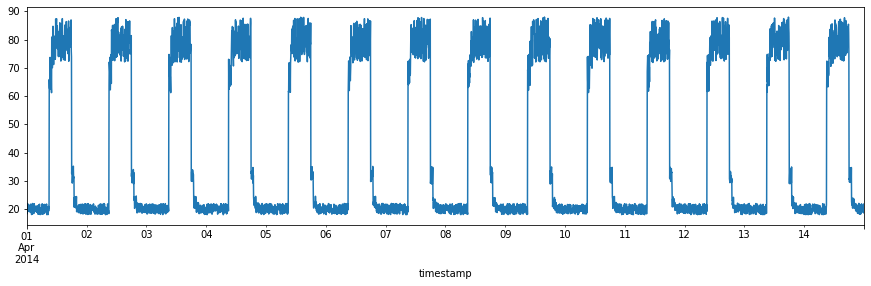

In [5]:
visualize_timeserie(df_small_noise)

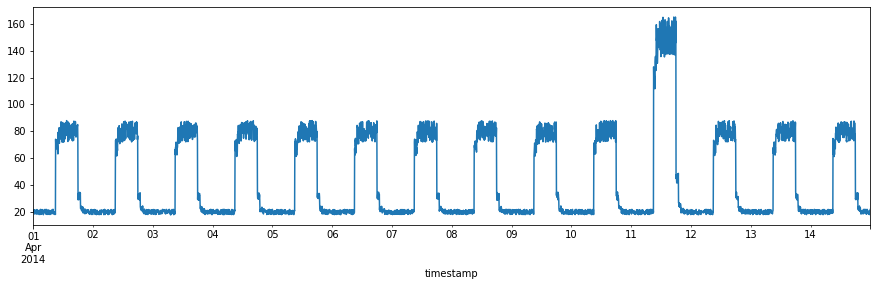

In [6]:
visualize_timeserie(df_daily_jumpsup)

In [7]:
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training = (df_small_noise - training_mean) / training_std
df_training.shape

(4032, 1)

In [8]:
TIME_STEPS = 288


def create_sequences(
    values: np.ndarray, time_steps: int = TIME_STEPS
) -> torch.FloatTensor:
    '''Create daily sequences
    '''
    output = [values[i:(i + time_steps)] for i in range(len(values) - time_steps)]
    return torch.FloatTensor(output).permute(0, 2, 1)

In [9]:
X = create_sequences(df_training.values)
X_train, X_valid = train_test_split(X, train_size=0.9, shuffle=False)

dataloader = {
    'train': DataLoader(X_train, batch_size=4),
    'valid': DataLoader(X_valid, batch_size=4),
}

# Model

In [10]:
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.Conv1d(32, 16, kernel_size=7, padding=3),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(16, 16, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.ConvTranspose1d(16, 32, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 1, kernel_size=7, padding=3)
        )
        
    def forward(self, sample):
        latent = self.encoder(sample)
        reconstructed = self.decoder(latent)
        return reconstructed

# Train

In [11]:
def train_model(
    model: nn.Module,
    dataloader: Dict[str, DataLoader],
    criterion: nn.Module,
    optimizer: nn.Module,
    epochs: int = 25
) -> Dict[str, List[float]]:
    """Training the model. Returns dictionary of train and validation losses.
    Args:
        model (torch.nn.Module): Neural network
        dataloader (Dict[str, DataLoader]):
            Dictionary with 'train' and 'valid' dataloaders
        criterion (torch.nn.Module): Cost function
        optimizer (torch.nn.Module): Optimization algorithm
        epochs (int): Number of training iterations. Default: 50
    """

    losses = {'train': [], 'valid': []}
    progress = tqdm(range(epochs), desc='Epoch')
    
    for epoch in progress:
        for phase in ['train', 'valid']:
            loss_accum = []
            model.train(mode=(phase == 'train'))
            
            for inputs in dataloader[phase]:
                inputs = inputs.to(DEVICE)
                
                if phase == 'train':
                    optimizer.zero_grad()
                    outp = model(inputs)
                    loss = criterion(outp, inputs)
                    loss.backward()
                    optimizer.step()
                else:
                    with torch.no_grad():
                        outp = model(inputs)
                        loss = criterion(outp, inputs)
                
                loss_accum.append(loss.item())
            
            phase_loss = np.mean(loss_accum)
            losses[phase].append(phase_loss)
            progress.set_description('loss: {:.4f}'.format(phase_loss))

    return losses

In [12]:
N_EPOCHS = 20

model = Autoencoder().to(DEVICE)

losses = train_model(
    model=model,
    dataloader=dataloader,
    criterion=nn.MSELoss(),
    optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
    epochs=N_EPOCHS,
)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

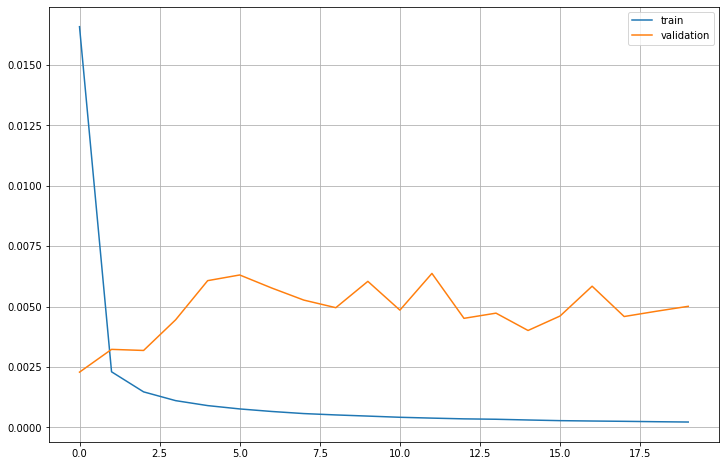

In [13]:
def show_metrics(metrics: Dict[str, List[float]]) -> None:
    plt.figure(figsize=(12, 8))
    plt.plot(metrics['train'], label='train')
    plt.plot(metrics['valid'], label='validation')
    plt.grid()
    plt.legend()
    plt.show()

    
# look at loss function...
show_metrics(losses)

# Alarm threshold

In [14]:
def evaluate_model(
    model: nn.Module, dataloader: DataLoader
) -> Tuple[List[float], List[float]]:
    
    losses:List[float] = list()
    preds:List[float] = list()
        
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            pred = model(batch.to(DEVICE)).cpu().numpy()
            preds.append(pred.ravel())
            loss = np.mean(np.abs(pred - batch.numpy()))
            losses.append(loss)
    return (losses, preds)

In [15]:
dataloader_full: DataLoader = DataLoader(X, batch_size=1)
losses, preds = evaluate_model(model=model, dataloader=dataloader_full)
            
threshold: float = 0.    
for loss in losses:
    if loss > threshold:
        threshold = loss

print(f'small_noise threshold: {threshold}')

small_noise threshold: 0.057048216462135315


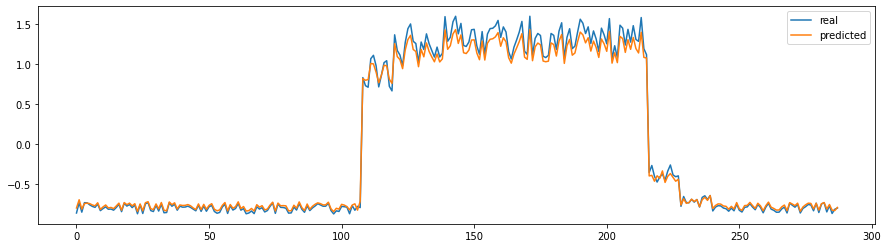

In [16]:
plt.figure(figsize=(15, 4))
plt.plot(X_train[0].numpy().ravel(), label='real')
plt.plot(preds[0], label='predicted')
plt.legend()
plt.show()

# Test 1

In [17]:
df_testing = (df_daily_jumpsup - training_mean) / training_std
x_test = create_sequences(df_testing.values)
dataloader_test = DataLoader(x_test, shuffle=False)
x_test.shape

torch.Size([3744, 1, 288])

In [18]:
test_losses, test_preds = evaluate_model(model=model, dataloader=dataloader_test)

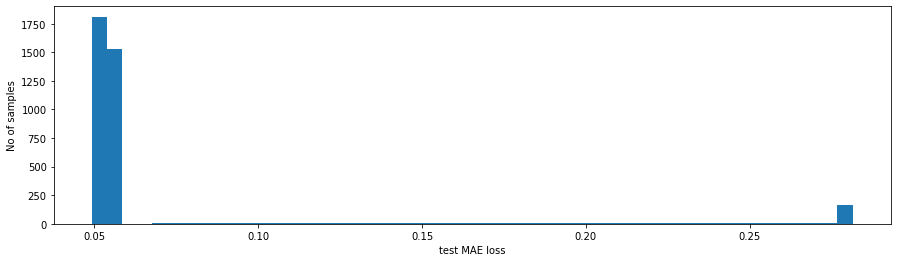

In [19]:
plt.figure(figsize=(15, 4))
plt.hist(test_losses, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

In [20]:
anomalies = test_losses > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  403
Indices of anomaly samples:  (array([2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711,
       2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722,
       2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733,
       2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744,
       2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755,
       2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766,
       2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777,
       2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788,
       2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799,
       2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810,
       2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821,
       2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832,
       2833, 2834, 2835, 2836, 2837, 2838, 2839, 2840, 2841, 2

In [21]:
def get_anomaly_idxs(df: pd.DataFrame, anomalies: np.ndarray) -> List[int]:
    anomaly_idxs: List[int] = list()
    start = TIME_STEPS - 1
    for idx in range(start, len(df) - start):
        if np.all(anomalies[(idx - start):idx]):
            anomaly_idxs.append(idx)
    return anomaly_idxs

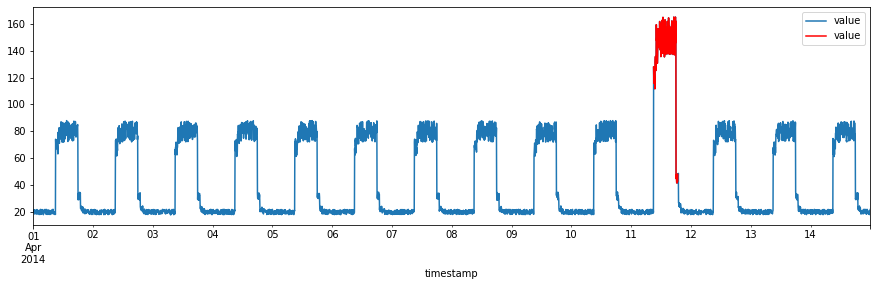

In [22]:
anomaly_idxs = get_anomaly_idxs(dataloader_test, anomalies)
df_anomaly = df_daily_jumpsup.iloc[anomaly_idxs]

fig, ax = plt.subplots(figsize=(15, 4))
df_daily_jumpsup.plot(ax=ax)
df_anomaly.plot(ax=ax, color='red')
plt.show()

# Test 2

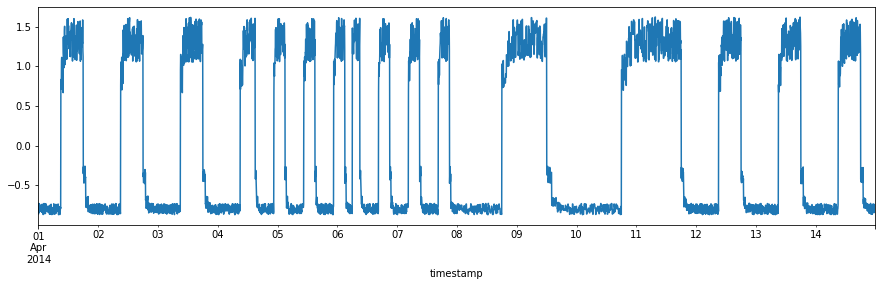

In [23]:
df_parts = np.array_split(df_training, 4)

values1 = df_parts[1].value.values
values2x = np.concatenate([values1, values1])[::2]
df_parts[1].value = values2x

values2 = df_parts[2].value.values
values05x = np.repeat(values2, 2)[:len(values2)]
df_parts[2].value = values05x

df_testing2 = pd.concat(df_parts)
visualize_timeserie(df_testing2)

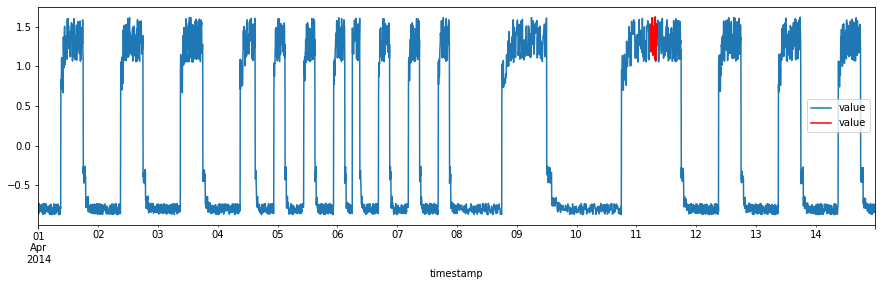

In [24]:
x_test2 = create_sequences(df_testing2.values)
dataloader_test2 = DataLoader(x_test2, shuffle=False)

test_losses2, test_preds2 = evaluate_model(model=model, dataloader=dataloader_test2)

anomalies2 = test_losses2 > threshold
anomaly_idxs2 = get_anomaly_idxs(dataloader_test2, anomalies2)
df_anomaly2 = df_testing2.iloc[anomaly_idxs2]

fig, ax = plt.subplots(figsize=(15, 4))
df_testing2.plot(ax=ax)
df_anomaly2.plot(ax=ax, color='red')
plt.show()

**:(**